Import Required Libraries

In [18]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model saving
import joblib

# Utility
import warnings
import re

# Scikit-learn: preprocessing, modeling, evaluation
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, f1_score, log_loss, precision_score,
    recall_score, roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Handle class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# XGBoost classifier
from xgboost import XGBClassifier

# Importing decision tree classifier from scikit-learn for building tree-based models
from sklearn.tree import DecisionTreeClassifier  


Read the BRFSS 2015 heart disease dataset from a CSV file into a pandas DataFrame for further analysis.

In [2]:

heart_disease_df = pd.read_csv('/Users/mky/Desktop/ml project summer 2025/heart_disease_health_indicators_BRFSS2015.csv',  encoding='utf-8')
print(heart_disease_df.shape)
heart_disease_df.head()

(253680, 22)


,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
print(heart_disease_df['HeartDiseaseorAttack'].value_counts())

HeartDiseaseorAttack
0.0    229787
1.0     23893
Name: count, dtype: int64


In [4]:
print(heart_disease_df['HeartDiseaseorAttack'].value_counts())

HeartDiseaseorAttack
0.0    229787
1.0     23893
Name: count, dtype: int64


 Identify Non-Standard Missing Values
Detect and count occurrences of dirty string values (e.g., 'nan', 'null', 'n/a', '-') across all columns to ensure data cleanliness.

In [5]:
dirty_values = ['nan', 'null', 'na', 'missing', '-', '--', 'n/a']
pattern = r'^(' + '|'.join(map(re.escape, dirty_values)) + r')$'
dirty_mask = heart_disease_df.applymap(
    lambda x: isinstance(x, str) and bool(re.match(pattern, x.strip(), re.IGNORECASE))
)

dirty_counts = dirty_mask.sum()
dirty_counts = dirty_counts[dirty_counts > 0]

print(" Columns containing dirty/missing string values (case-insensitive):")
print(dirty_counts)


/var/folders/86/yt7z0g3j3xbds04jw0_x0sqr0000gn/T/ipykernel_65633/2376662050.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dirty_mask = heart_disease_df.applymap(


 Columns containing dirty/missing string values (case-insensitive):
Series([], dtype: int64)


Detect Duplicate Records
Check for and report the total number of duplicate rows in the dataset to avoid redundancy and ensure data integrity.

In [6]:

duplicates = heart_disease_df.duplicated()
total_duplicates = duplicates.sum()

print(f" Total duplicate rows: {total_duplicates}")
if total_duplicates > 0:
    print("\n Duplicate rows:")
    print(heart_disease_df[duplicates])
else:
    print(" No duplicate rows found.")

 Total duplicate rows: 23899

 Duplicate rows:
        HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  \
1242                     0.0     1.0       1.0        1.0  27.0     1.0   
1563                     0.0     0.0       0.0        1.0  21.0     1.0   
2700                     0.0     0.0       0.0        1.0  32.0     0.0   
3160                     0.0     0.0       0.0        1.0  21.0     0.0   
3332                     0.0     0.0       0.0        1.0  24.0     0.0   
...                      ...     ...       ...        ...   ...     ...   
253492                   0.0     1.0       1.0        1.0  33.0     0.0   
253550                   0.0     0.0       0.0        1.0  25.0     0.0   
253563                   0.0     0.0       1.0        1.0  24.0     1.0   
253597                   0.0     0.0       0.0        1.0  24.0     0.0   
253638                   0.0     0.0       0.0        1.0  24.0     0.0   

        Stroke  Diabetes  PhysActivity  Fruits  ... 

In [7]:

heart_disease_df_cleaned = heart_disease_df.drop_duplicates()
print("After removing duplicates:")
print(f"Original shape: {heart_disease_df.shape}")
print(f"New shape: {heart_disease_df_cleaned.shape}")


After removing duplicates:
Original shape: (253680, 22)
New shape: (229781, 22)


In [8]:
heart_disease_df_cleaned .info()

<class 'pandas.core.frame.DataFrame'>
Index: 229781 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  229781 non-null  float64
 1   HighBP                229781 non-null  float64
 2   HighChol              229781 non-null  float64
 3   CholCheck             229781 non-null  float64
 4   BMI                   229781 non-null  float64
 5   Smoker                229781 non-null  float64
 6   Stroke                229781 non-null  float64
 7   Diabetes              229781 non-null  float64
 8   PhysActivity          229781 non-null  float64
 9   Fruits                229781 non-null  float64
 10  Veggies               229781 non-null  float64
 11  HvyAlcoholConsump     229781 non-null  float64
 12  AnyHealthcare         229781 non-null  float64
 13  NoDocbcCost           229781 non-null  float64
 14  GenHlth               229781 non-null  float64
 15  MentH

In [9]:
heart_disease_df_cleaned.to_csv('heart_disease_df_cleaned.csv', index=False)
print(" File 'heart_disease_df_cleaned.csv' saved in your project folder.")

 File 'heart_disease_df_cleaned.csv' saved in your project folder.


Exploratory Data Analysis (EDA) Visualizations

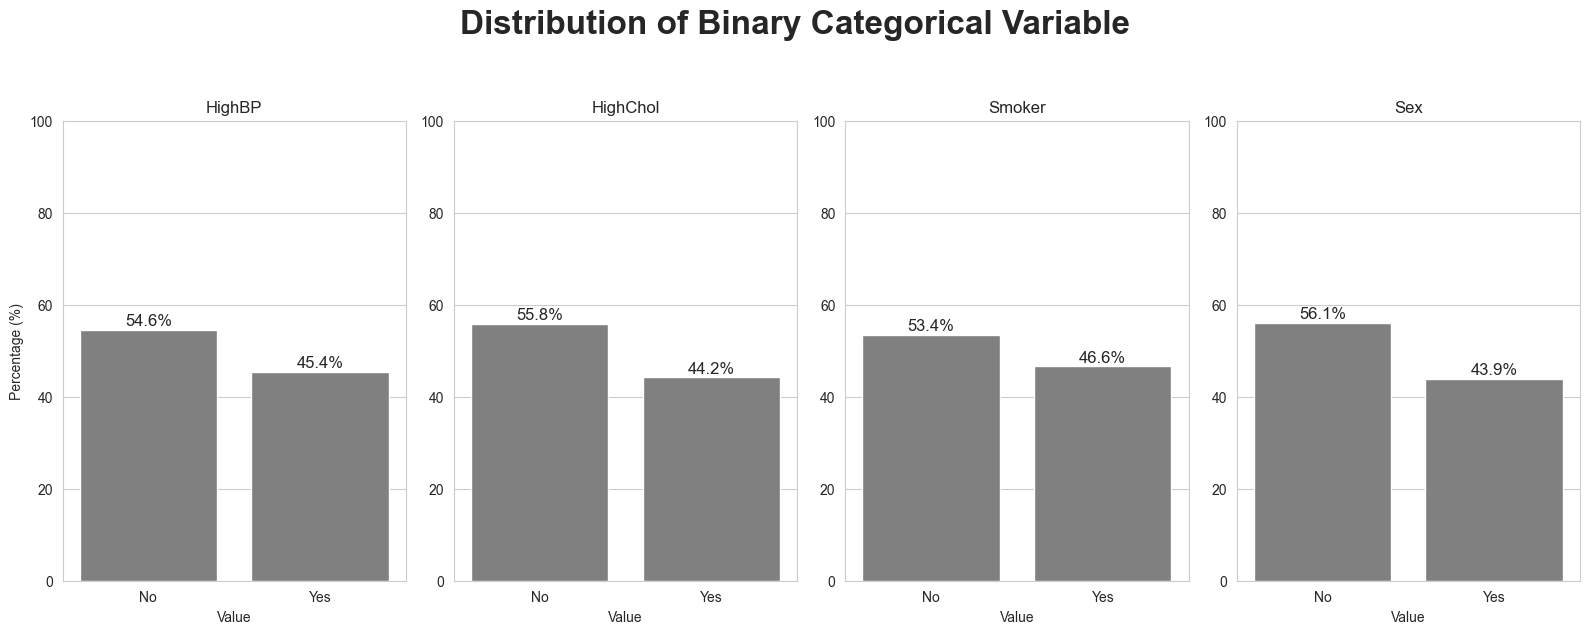

In [11]:
df = pd.read_csv("heart_disease_df_cleaned.csv")

binary_cols = ['HighBP', 'HighChol', 'Smoker', 'Sex'] 

sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))
plt.suptitle("Distribution of Binary Categorical Variable", fontsize=24, fontweight='bold', y=1.05)

for i, col in enumerate(binary_cols):
    plt.subplot(1, len(binary_cols), i + 1)
    percentage = df[col].value_counts(normalize=True) * 100
    ax = sns.barplot(x=percentage.index.map({0: "No", 1: "Yes"}), y=percentage.values, color='gray')
    for p, v in zip(ax.patches, percentage.values):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 1, f'{v:.1f}%', ha='center', fontsize=12)
    plt.title(col)
    plt.ylim(0, 100)
    plt.ylabel("Percentage (%)" if i == 0 else "")
    plt.xlabel("Value")

plt.tight_layout()
plt.show()


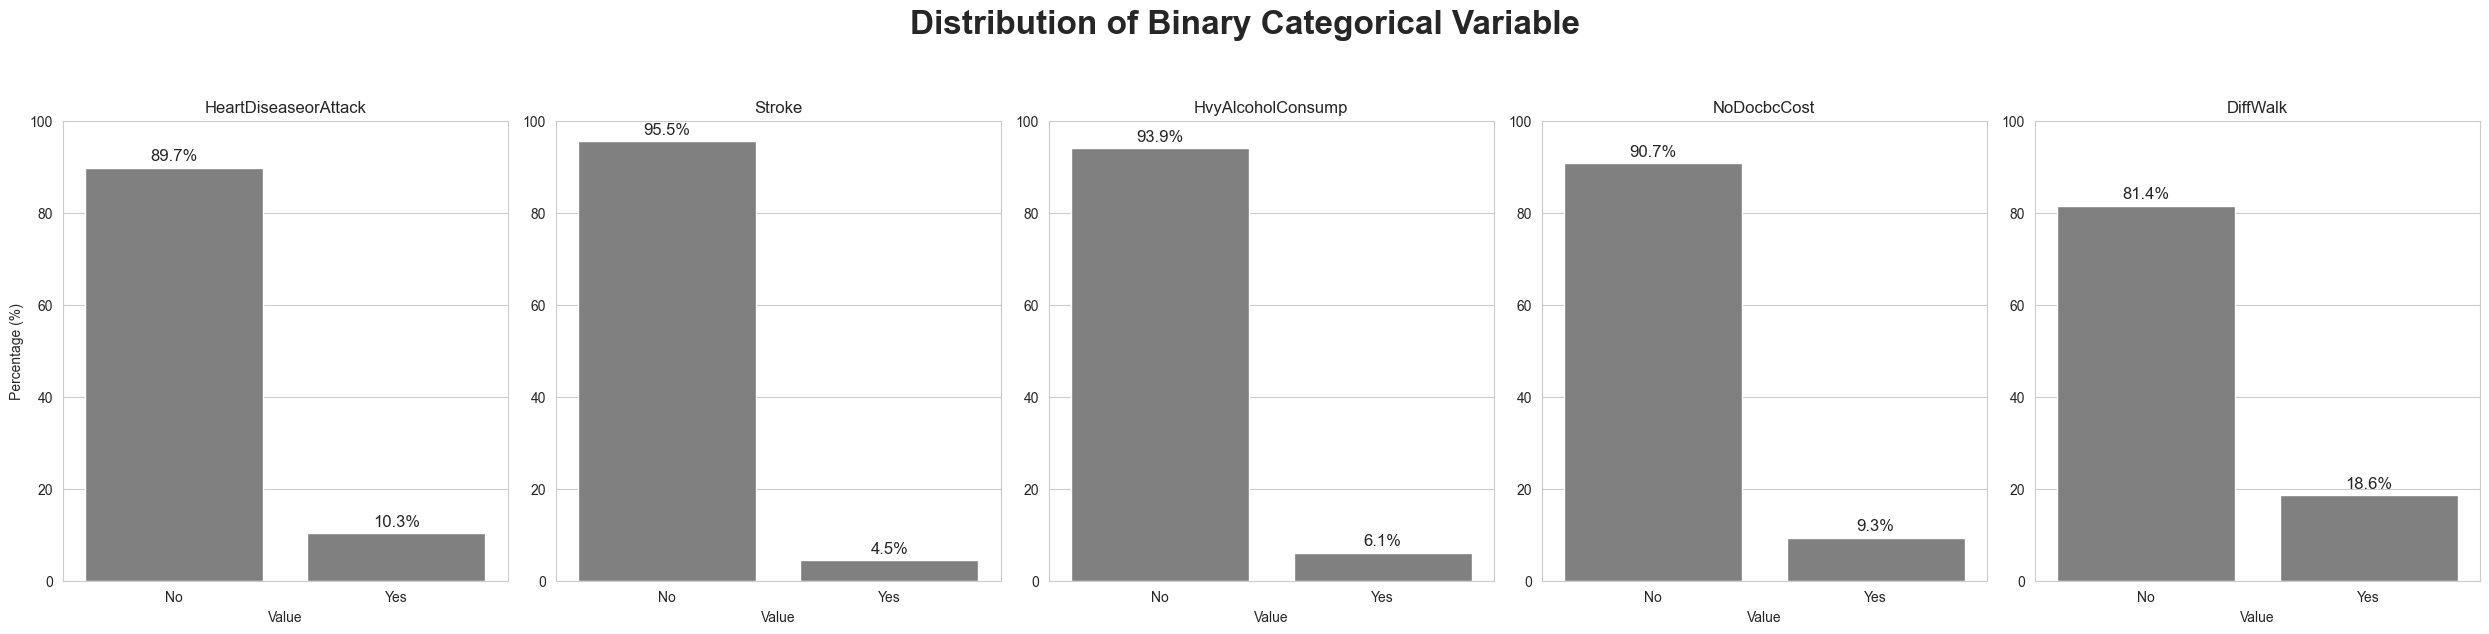

In [12]:

def plot_binary_distributions(df, binary_cols, title="Distribution of Binary Categorical Variable"):
    sns.set_style("whitegrid")
    num_vars = len(binary_cols)
    plt.figure(figsize=(5 * num_vars, 6))
    plt.suptitle(title, fontsize=24, fontweight='bold', y=1.05)

    for i, col in enumerate(binary_cols):
        plt.subplot(1, num_vars, i + 1)
        percentages = df[col].value_counts(normalize=True) * 100
        labels = percentages.index.map({0: "No", 1: "Yes"})
        ax = sns.barplot(x=labels, y=percentages.values, color='gray')

        for bar, pct in zip(ax.patches, percentages.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=12)

        plt.title(col)
        plt.xlabel("Value")
        plt.ylabel("Percentage (%)" if i == 0 else "")
        plt.ylim(0, 100)

    plt.tight_layout()
    plt.show()


binary_cols_2 = ['HeartDiseaseorAttack', 'Stroke', 'HvyAlcoholConsump', 'NoDocbcCost', 'DiffWalk']
plot_binary_distributions(df, binary_cols_2)


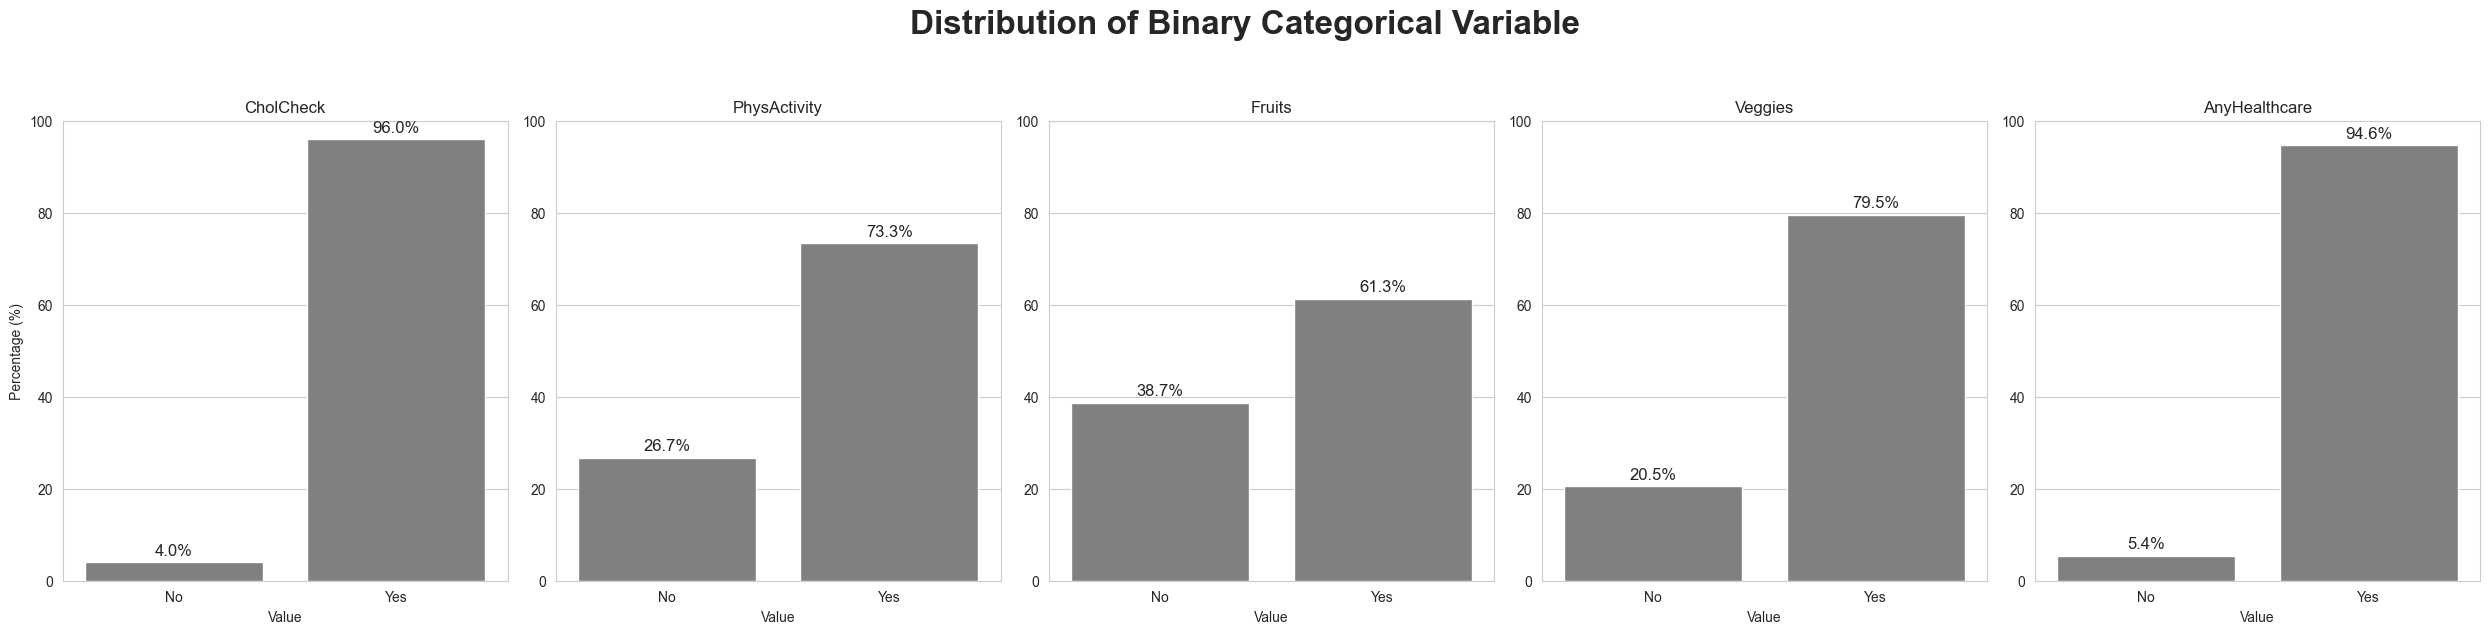

In [13]:

def plot_binary_distributions(df, binary_cols, title="Distribution of Binary Categorical Variable"):
    sns.set_style("whitegrid")
    num_vars = len(binary_cols)
    plt.figure(figsize=(5 * num_vars, 6))
    plt.suptitle(title, fontsize=24, fontweight='bold', y=1.05)

    for i, col in enumerate(binary_cols):
        plt.subplot(1, num_vars, i + 1)
        percentages = df[col].value_counts(normalize=True).sort_index() * 100
        labels = percentages.index.map({0: "No", 1: "Yes"})
        ax = sns.barplot(x=labels, y=percentages.values, color='gray')

        for bar, pct in zip(ax.patches, percentages.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=12)

        plt.title(col)
        plt.xlabel("Value")
        plt.ylabel("Percentage (%)" if i == 0 else "")
        plt.ylim(0, 100)

    plt.tight_layout()
    plt.show()


binary_cols_3 = ['CholCheck', 'PhysActivity', 'Fruits', 'Veggies', 'AnyHealthcare']
plot_binary_distributions(df, binary_cols_3)


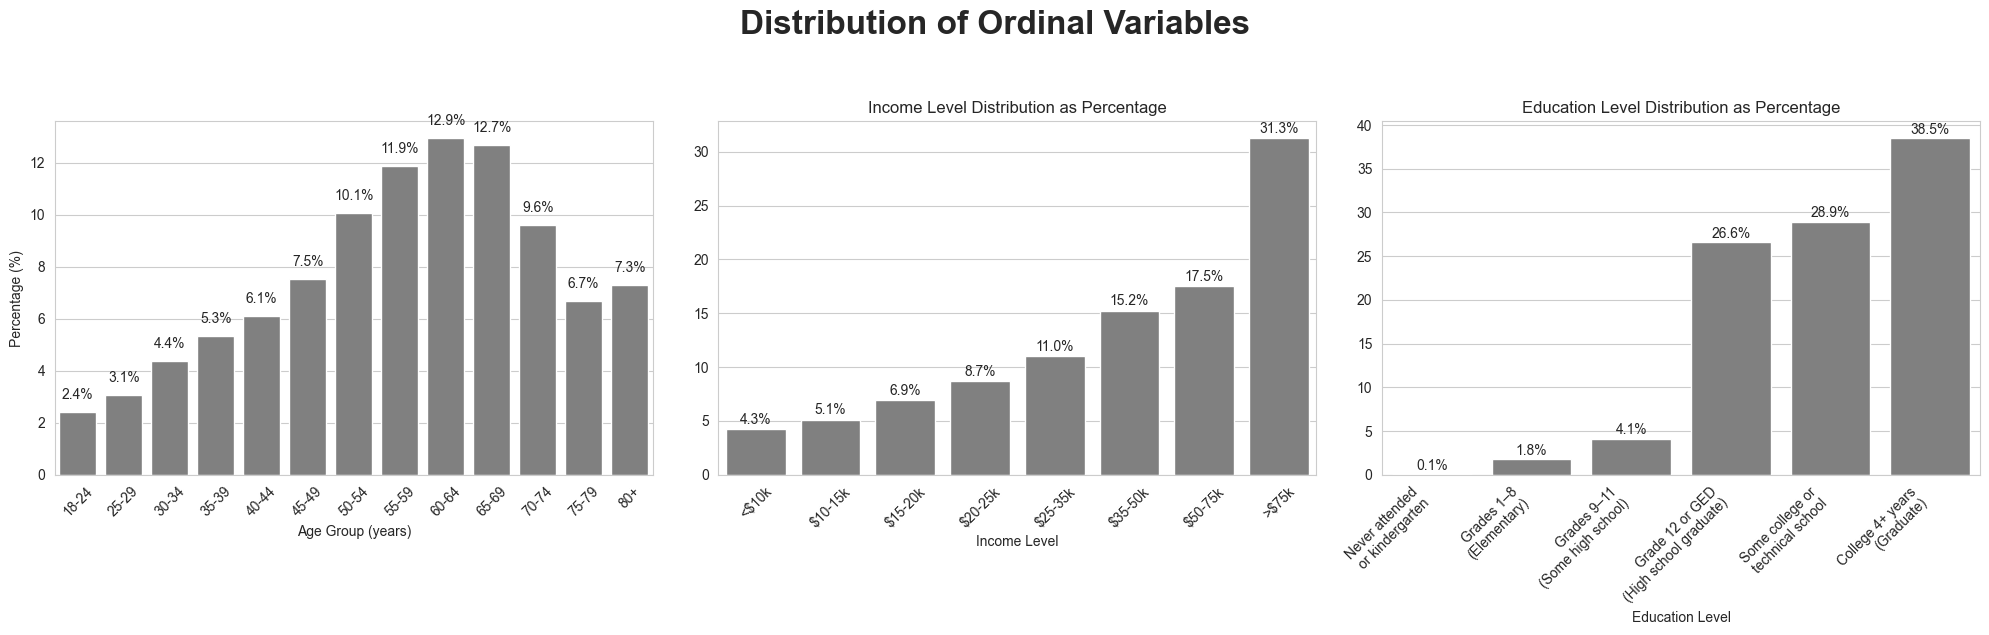

In [14]:

age_labels = [
    '18-24', '25-29', '30-34', '35-39', '40-44', '45-49',
    '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+'
]
income_labels = [
    '<$10k', '$10-15k', '$15-20k', '$20-25k', '$25-35k',
    '$35-50k', '$50-75k', '>$75k'
]
education_labels = [
    'Never attended\nor kindergarten',
    'Grades 1–8\n(Elementary)',
    'Grades 9–11\n(Some high school)',
    'Grade 12 or GED\n(High school graduate)',
    'Some college or\ntechnical school',
    'College 4+ years\n(Graduate)'
]


sns.set_style("whitegrid")

plt.figure(figsize=(20, 6))
plt.suptitle("Distribution of Ordinal Variables", fontsize=24, fontweight='bold', y=1.05)

plt.subplot(1, 3, 1)
age_pct = df['Age'].value_counts(normalize=True).sort_index() * 100
sns.barplot(x=age_labels, y=age_pct.values, color='gray')
plt.xticks(rotation=45)
for i, pct in enumerate(age_pct.values):
    plt.text(i, pct + 0.5, f'{pct:.1f}%', ha='center')
plt.ylabel('Percentage (%)')
plt.xlabel('Age Group (years)')

plt.subplot(1, 3, 2)
income_pct = df['Income'].value_counts(normalize=True).sort_index() * 100
sns.barplot(x=income_labels, y=income_pct.values, color='gray')
plt.xticks(rotation=45)
for i, pct in enumerate(income_pct.values):
    plt.text(i, pct + 0.5, f'{pct:.1f}%', ha='center')
plt.title('Income Level Distribution as Percentage')
plt.ylabel('')
plt.xlabel('Income Level')

plt.subplot(1, 3, 3)
edu_pct = df['Education'].value_counts(normalize=True).sort_index() * 100
sns.barplot(x=education_labels, y=edu_pct.values, color='gray')
plt.xticks(rotation=45, ha='right')
for i, pct in enumerate(edu_pct.values):
    plt.text(i, pct + 0.5, f'{pct:.1f}%', ha='center')
plt.title('Education Level Distribution as Percentage')
plt.ylabel('')
plt.xlabel('Education Level')

plt.tight_layout()
plt.show()


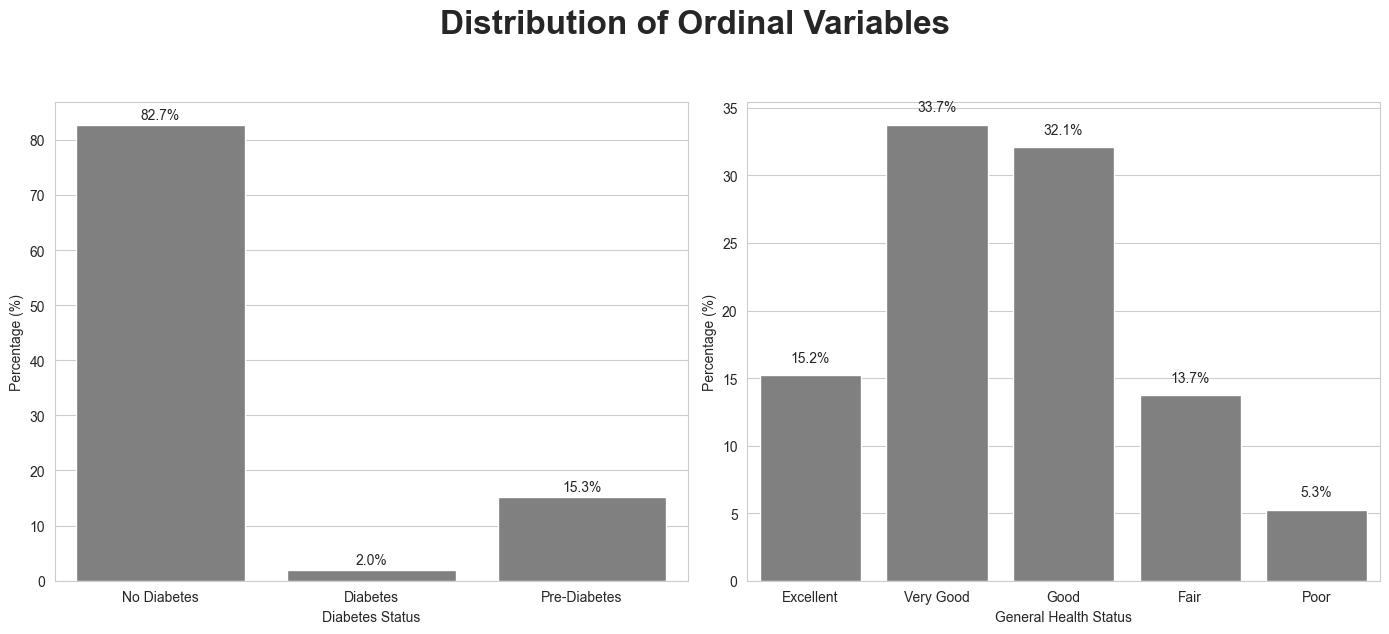

In [15]:


diabetes_labels = ['No Diabetes', 'Diabetes', 'Pre-Diabetes']
genhlth_labels = ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor']

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))
plt.suptitle("Distribution of Ordinal Variables", fontsize=24, fontweight='bold', y=1.05)

plt.subplot(1, 2, 1)
diabetes_pct = df['Diabetes'].value_counts(normalize=True).sort_index() * 100
sns.barplot(x=diabetes_labels, y=diabetes_pct.values, color='gray')
for i, pct in enumerate(diabetes_pct.values):
    plt.text(i, pct + 1, f'{pct:.1f}%', ha='center')
plt.ylabel('Percentage (%)')
plt.xlabel('Diabetes Status')

plt.subplot(1, 2, 2)
genhlth_pct = df['GenHlth'].value_counts(normalize=True).sort_index() * 100
sns.barplot(x=genhlth_labels, y=genhlth_pct.values, color='gray')
for i, pct in enumerate(genhlth_pct.values):
    plt.text(i, pct + 1, f'{pct:.1f}%', ha='center')
plt.ylabel('Percentage (%)')
plt.xlabel('General Health Status')

plt.tight_layout()
plt.show()


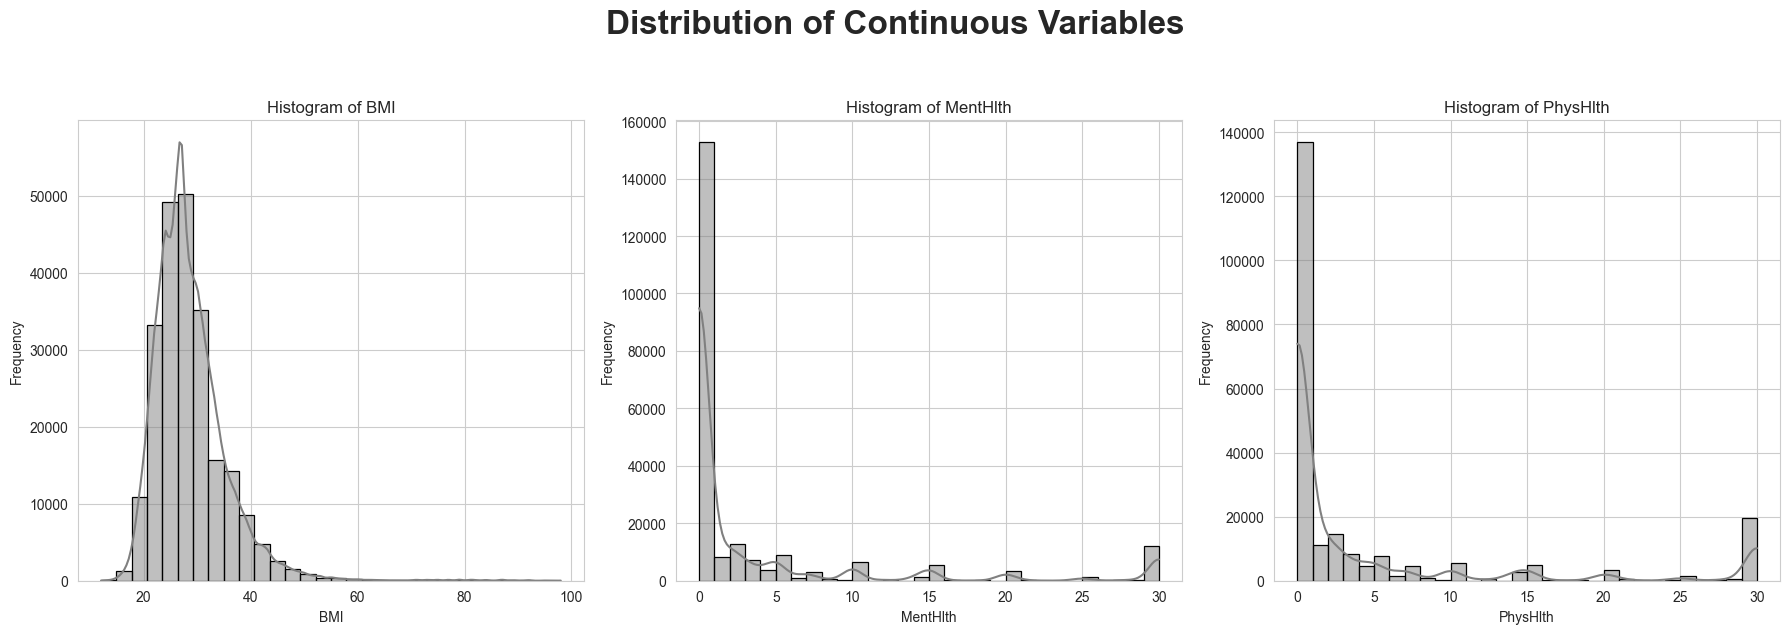

In [16]:

sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))
plt.suptitle("Distribution of Continuous Variables", fontsize=24, fontweight='bold', y=1.05)


continuous_vars = ['BMI', 'MentHlth', 'PhysHlth']
for i, col in enumerate(continuous_vars):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data=df, x=col, kde=True, bins=30, color='gray', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


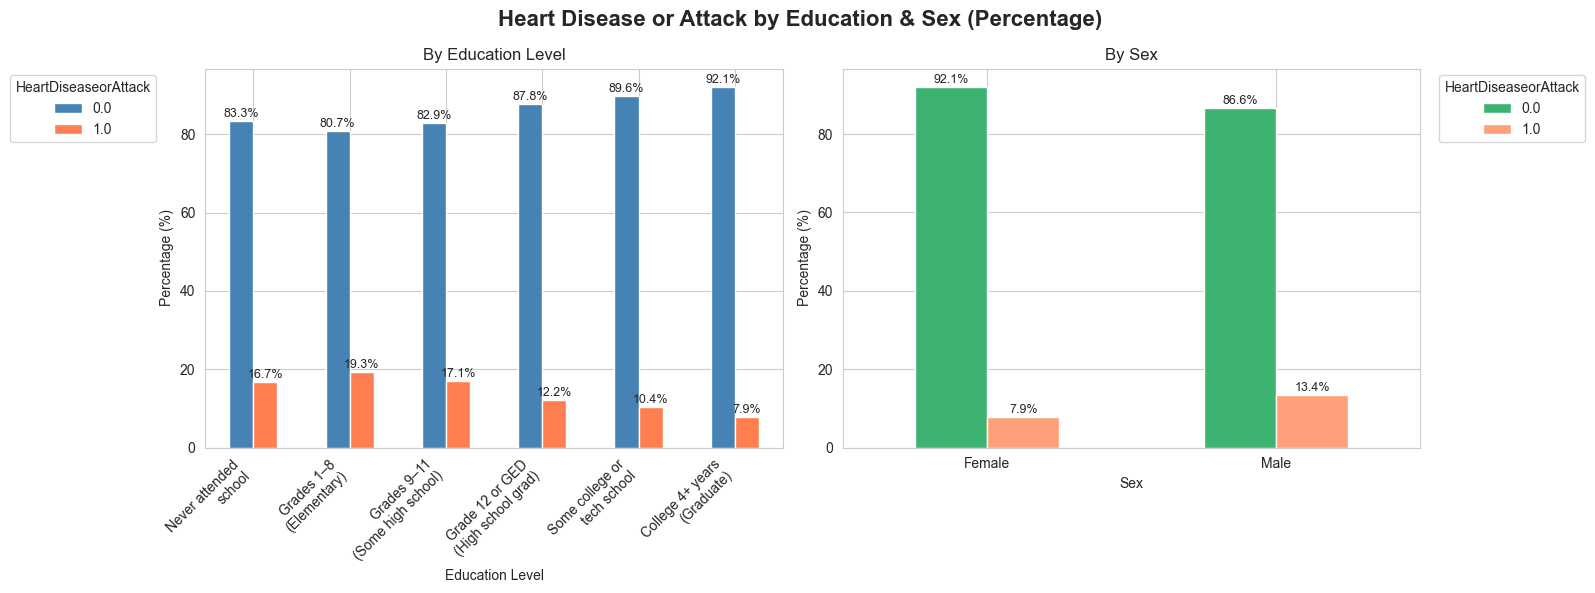

In [17]:


education_labels = [
    'Never attended\nschool',
    'Grades 1–8\n(Elementary)',
    'Grades 9–11\n(Some high school)',
    'Grade 12 or GED\n(High school grad)',
    'Some college or\ntech school',
    'College 4+ years\n(Graduate)'
]
sex_labels = ['Female', 'Male']


sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Heart Disease or Attack by Education & Sex (Percentage)", fontsize=16, fontweight="bold")

edu_group = df.groupby(['Education', 'HeartDiseaseorAttack']).size().unstack()
edu_pct = edu_group.div(edu_group.sum(axis=1), axis=0) * 100
ax1 = axes[0]
edu_pct.plot(kind='bar', stacked=False, ax=ax1, color=['steelblue', 'coral'])
ax1.set_title("By Education Level")
ax1.set_ylabel("Percentage (%)")
ax1.set_xlabel("Education Level")
ax1.set_xticks(range(len(education_labels)))
ax1.set_xticklabels(education_labels, rotation=45, ha='right')
ax1.legend(title="HeartDiseaseorAttack", loc='upper left', bbox_to_anchor=(-0.35, 1))

for container in ax1.containers:
    for bar in container:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontsize=9)

sex_group = df.groupby(['Sex', 'HeartDiseaseorAttack']).size().unstack()
sex_pct = sex_group.div(sex_group.sum(axis=1), axis=0) * 100
ax2 = axes[1]
sex_pct.plot(kind='bar', stacked=False, ax=ax2, color=['mediumseagreen', 'lightsalmon'])
ax2.set_title("By Sex")
ax2.set_ylabel("Percentage (%)")
ax2.set_xlabel("Sex")
ax2.set_xticks([0, 1])
ax2.set_xticklabels(sex_labels, rotation=0)
ax2.legend(title="HeartDiseaseorAttack", loc='upper left', bbox_to_anchor=(1.02, 1))

for container in ax2.containers:
    for bar in container:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


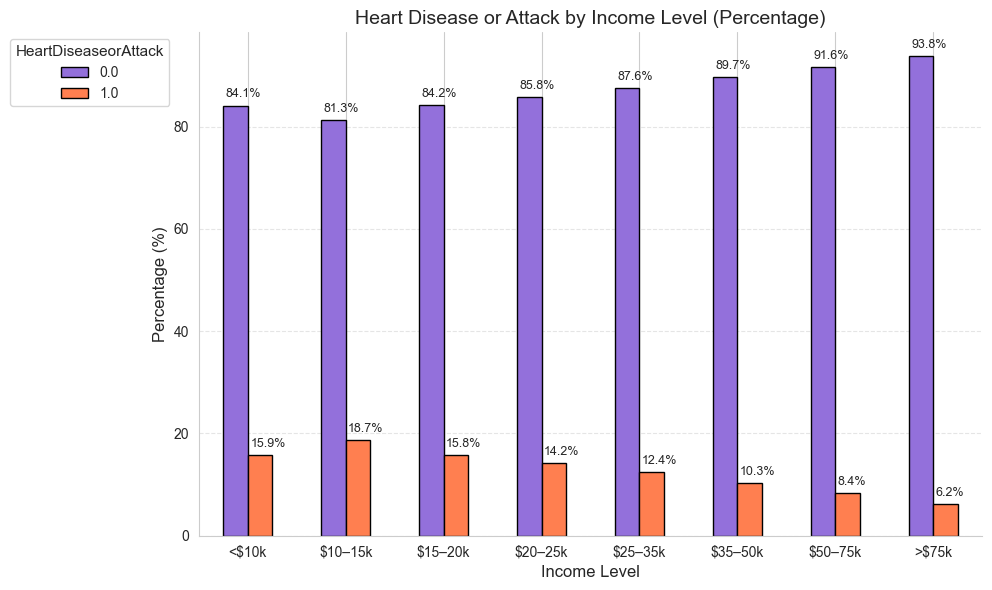

In [19]:

income_labels = [
    "<$10k", "$10–15k", "$15–20k", "$20–25k", "$25–35k",
    "$35–50k", "$50–75k", ">$75k"
]

income_group = df.groupby(['Income', 'HeartDiseaseorAttack']).size().unstack()
income_pct = income_group.div(income_group.sum(axis=1), axis=0) * 100
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['mediumpurple', 'coral']
income_pct.plot(kind='bar', ax=ax, color=colors, edgecolor='black')

ax.set_title("Heart Disease or Attack by Income Level (Percentage)", fontsize=14)
ax.set_xlabel("Income Level", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_xticks(range(len(income_labels)))
ax.set_xticklabels(income_labels, rotation=0, fontsize=10)
ax.tick_params(axis='y', labelsize=10)


ax.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() * 0.10,  
            height + 1,                            
            f'{height:.1f}%',
            ha='left',                            
            va='bottom',
            fontsize=9
        )


ax.legend(title="HeartDiseaseorAttack", loc='upper left', bbox_to_anchor=(-0.25, 1), fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()


Correlation Matrix Visualization for Analyzing Inter-Feature Relationships

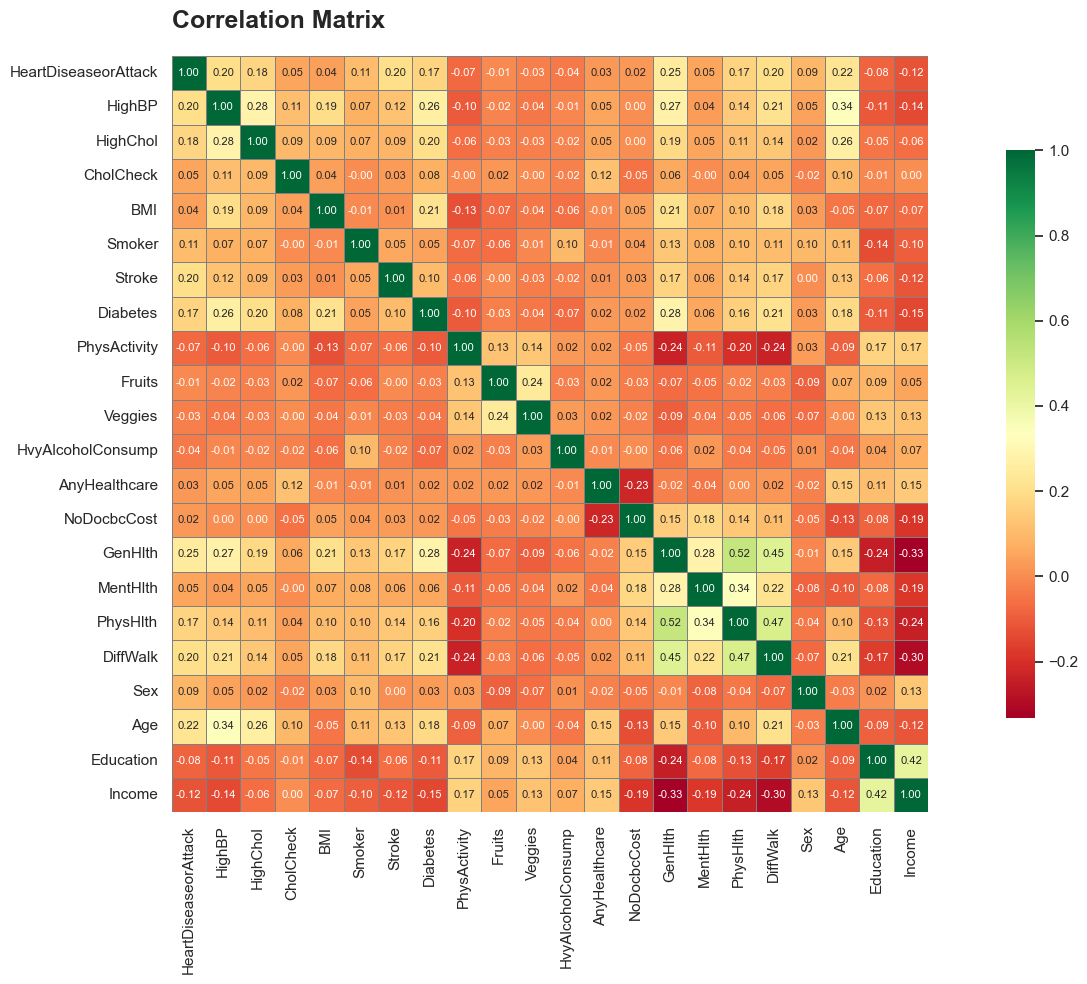

In [20]:

corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.0)

heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.75},
    annot_kws={"size": 8}
)

plt.title("Correlation Matrix", fontsize=18, weight='bold', loc='left', pad=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [10]:

df = pd.read_csv("heart_disease_df_cleaned.csv").copy()
df.head()


,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Logistic Regression Modeling and Evaluation
The cleaned dataset was loaded, and the feature matrix (X) and target variable (y) were defined.
The data was partitioned into training and testing sets using a 70/30 stratified split to preserve class balance.
A machine learning pipeline was constructed, incorporating standard scaling for numerical features and a Logistic Regression classifier.
The model was trained on the training set and evaluated on the test set using key classification metrics, including precision, recall, F1 score, and accuracy.

In [11]:


heart_disease_df_cleaned = pd.read_csv("heart_disease_df_cleaned.csv")


X = heart_disease_df_cleaned.drop(columns=["HeartDiseaseorAttack"])
y = heart_disease_df_cleaned["HeartDiseaseorAttack"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)



pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     61820
         1.0       0.54      0.12      0.20      7115

    accuracy                           0.90     68935
   macro avg       0.72      0.56      0.57     68935
weighted avg       0.87      0.90      0.87     68935



Dataset Preparation and Preprocessing Strategy
The cleaned dataset was loaded, and the feature matrix (X) and target variable (y) were defined.
Features were categorized into continuous, ordinal, and binary groups to enable appropriate preprocessing strategies.
The dataset was split into training and testing subsets using a 70/30 stratified split, ensuring that the class distribution was maintained across both sets.

In [13]:


df = pd.read_csv("heart_disease_df_cleaned.csv")
X = df.drop(columns=["HeartDiseaseorAttack"])
y = df["HeartDiseaseorAttack"]
continuous_vars = ['BMI', 'MentHlth', 'PhysHlth']
ordinal_vars = ['Age', 'Education', 'Income', 'GenHlth']
scaled_features = continuous_vars + ordinal_vars
binary_vars = [col for col in X.columns if col not in scaled_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


Logistic Regression Pipeline Construction and Evaluation
A machine learning pipeline was constructed, incorporating preprocessing steps where continuous and ordinal features were scaled, and binary features were passed without modification.
SMOTE was applied to the training data to address class imbalance.
A Logistic Regression classifier was integrated into the pipeline.
The complete pipeline was fitted on the training set, and model performance was evaluated on the test set using a classification report.

In [14]:

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scaled_features),
        ('binary', 'passthrough', binary_vars)
    ]
)


pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(" Classification Report:\n")
print(classification_report(y_test, y_pred))


/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


 Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     61820
         1.0       0.26      0.78      0.39      7115

    accuracy                           0.74     68935
   macro avg       0.61      0.76      0.61     68935
weighted avg       0.89      0.74      0.79     68935



Logistic Regression Hyperparameter Tuning and Evaluation
Hyperparameter tuning was performed on a Logistic Regression pipeline that integrated preprocessing, SMOTE oversampling, and classification.
GridSearchCV was employed to optimize the following parameters:
Penalty type
Solver
Regularization strength (C)
ElasticNet mixing ratio (l1_ratio) (for elastic net penalty).
Optimization was based on F1 score using 5-fold cross-validation.
The best-performing model was subsequently evaluated on the test set, and a classification report was generated to summarize performance metrics.

In [31]:



pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])


param_grid = [
    {
        'classifier__penalty': ['l1'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__C': [0.01, 0.1, 1]
    },
    {
        'classifier__penalty': ['l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__C': [0.01, 0.1, 1]
    },
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__C': [0.01, 0.1, 1],
        'classifier__l1_ratio': [0.15, 0.5, 0.85]
    }
]



grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(" Best Parameters:", grid_search.best_params_)
print(" Best CV F1 Score: {:.4f}".format(grid_search.best_score_))
print(" Classification Report:\n", classification_report(y_test, y_pred))


/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-

 Best Parameters: {'classifier__C': 0.01, 'classifier__l1_ratio': 0.85, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}
 Best CV F1 Score: 0.3827
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     61820
         1.0       0.26      0.78      0.38      7115

    accuracy                           0.74     68935
   macro avg       0.61      0.76      0.61     68935
weighted avg       0.89      0.74      0.79     68935



Final Logistic Regression Model Deployment
Finalized and evaluated the best Logistic Regression pipeline by incorporating the hyperparameters optimized through GridSearchCV.
Trained the model on the training set and evaluated its performance on the test set using a classification report and confusion matrix.
The complete trained pipeline was saved as LogisticRegression_pipeline_model.pkl for future deployment and inference.

/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


 Final Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     61820
         1.0       0.26      0.78      0.38      7115

    accuracy                           0.74     68935
   macro avg       0.61      0.76      0.61     68935
weighted avg       0.89      0.74      0.79     68935



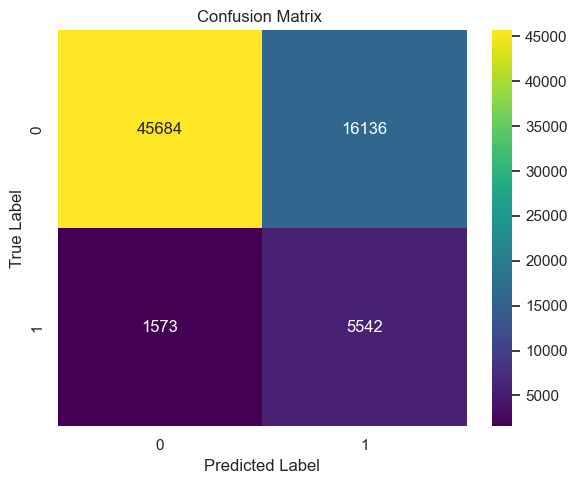

 Logistic Regression pipeline saved successfully


In [32]:


pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        C=0.01,
        penalty='elasticnet',
        l1_ratio=0.85,
        solver='saga',
        max_iter=1000,
        random_state=42
    ))
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(" Final Classification Report:\n")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True, linewidths=0, linecolor='none')

plt.title("Confusion Matrix ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

joblib.dump(pipeline, "LogisticRegression_pipeline_model.pkl")
print(" Logistic Regression pipeline saved successfully")



Decision Tree Model Development and Evaluation
Constructed a Decision Tree pipeline integrating feature preprocessing, SMOTE oversampling, and hyperparameter tuning using GridSearchCV.
Optimized key parameters: max_depth, min_samples_split, min_samples_leaf, and criterion, with selection based on the F1 score during 5-fold cross-validation.
Trained the best-performing model and evaluated its effectiveness on the test set using a classification report.

In [17]:

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [10, 20, 30],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=0,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(" Best Parameters:", grid_search.best_params_)
print(" Best CV F1 Score: {:.4f}".format(grid_search.best_score_))
print(" Classification Report:\n", classification_report(y_test, y_pred))


/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-

 Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 20}
 Best CV F1 Score: 0.3813
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.86      0.90     61820
         1.0       0.30      0.52      0.38      7115

    accuracy                           0.82     68935
   macro avg       0.62      0.69      0.64     68935
weighted avg       0.87      0.82      0.84     68935



Final Decision Tree Model Deployment
Finalized the Decision Tree model by constructing a pipeline with preprocessing, SMOTE oversampling, and the best hyperparameters identified through tuning.
Trained the model on the training set and evaluated its performance on the test set using a classification report.
Visualized the model's predictions with a confusion matrix.
Saved the complete trained pipeline for future deployment and inference.

 Classification Report (Decision Tree):

              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90     61820
         1.0       0.30      0.52      0.38      7115

    accuracy                           0.82     68935
   macro avg       0.62      0.69      0.64     68935
weighted avg       0.87      0.82      0.84     68935



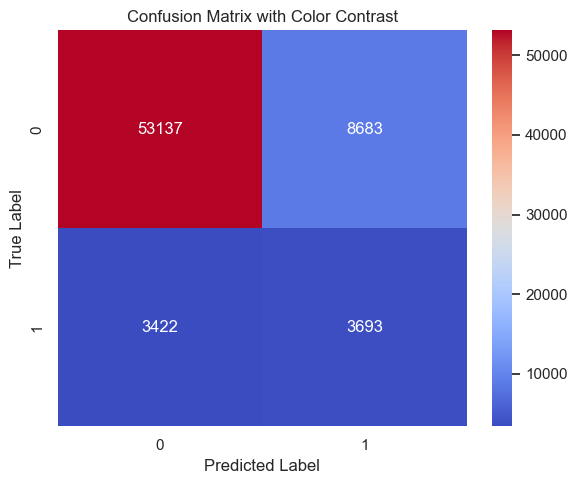

 Decision Tree pipeline saved as 'DecisionTree_pipeline_model.pkl'


In [65]:

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(
        criterion='gini',
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=5,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(" Classification Report (Decision Tree):\n")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=0, linecolor='none', cbar=True)

plt.title("Confusion Matrix with Color Contrast")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


joblib.dump(pipeline, "DecisionTree_pipeline_model.pkl")

print(" Decision Tree pipeline saved as 'DecisionTree_pipeline_model.pkl'")


Random Forest Model Deployment
Trained a Random Forest model within a pipeline that included feature preprocessing and SMOTE oversampling to address class imbalance.
Conducted hyperparameter tuning using GridSearchCV, optimizing parameters such as n_estimators and max_depth, with F1 score as the evaluation metric.
Evaluated the best-performing model on the test set using standard classification metrics.

In [51]:

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


param_grid = {
    'classifier__n_estimators': [100],             
    'classifier__max_depth': [10, 15],                  
    'classifier__max_features': ['sqrt', 'log2'],      
    'classifier__min_samples_split': [2, 10],           
    'classifier__min_samples_leaf': [1, 5]              
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


print("\n Best Parameters:", grid_search.best_params_)
print(" Best CV F1 Score: {:.4f}".format(grid_search.best_score_))
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred))


/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-


 Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
 Best CV F1 Score: 0.4052
Classification Report (Random Forest):
               precision    recall  f1-score   support

         0.0       0.95      0.83      0.88     61820
         1.0       0.30      0.64      0.40      7115

    accuracy                           0.81     68935
   macro avg       0.62      0.73      0.64     68935
weighted avg       0.88      0.81      0.84     68935



Final Random Forest Model Deployment
Finalized and trained a Random Forest pipeline incorporating preprocessing and SMOTE for class imbalance correction.
Evaluated the model's predictive performance on the test set using classification metrics and confusion matrix visualization.
Saved the trained pipeline as RandomForest_pipeline_model.pkl for reproducibility and future deployment.

 Final Classification Report (Random Forest):

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.88     61820
         1.0       0.30      0.64      0.40      7115

    accuracy                           0.81     68935
   macro avg       0.62      0.73      0.64     68935
weighted avg       0.88      0.81      0.84     68935



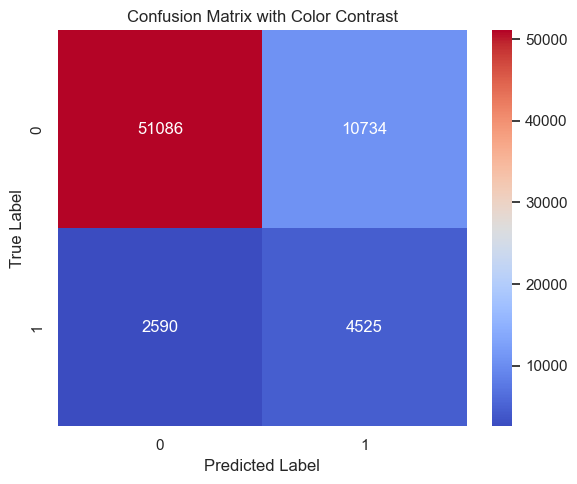

 Random Forest pipeline model saved as 'RandomForest_pipeline_model.pkl'


In [66]:

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features='sqrt',
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42
    ))
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(" Final Classification Report (Random Forest):\n")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=0, linecolor='none', cbar=True)
plt.title("Confusion Matrix with Color Contrast")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


joblib.dump(pipeline, "RandomForest_pipeline_model.pkl")

print(" Random Forest pipeline model saved as 'RandomForest_pipeline_model.pkl'")


XGBoost Model with Hyperparameter Tuning
A machine learning pipeline was constructed, integrating feature preprocessing, SMOTE-based oversampling to address class imbalance, and an XGBoost classifier.
Hyperparameter optimization was conducted using GridSearchCV with 5-fold cross-validation, tuning critical parameters including n_estimators, max_depth, learning_rate, subsample, and colsample_bytree.
The optimal model configuration, as determined through cross-validation, was subsequently trained on the full training dataset.
Model predictions were generated for the test set, and performance was assessed using comprehensive classification metrics.
The study reports the best-performing hyperparameter combination along with the corresponding F1 score, demonstrating the effectiveness of the tuned XGBoost model.

In [57]:

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])


param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n Best Parameters:", grid_search.best_params_)
print(" Best CV F1 Score: {:.4f}".format(grid_search.best_score_))
print(" Classification Report (XGBoost):\n", classification_report(y_test, y_pred))


/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mky/Library/Python/3.9/lib/python/site-


 Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
 Best CV F1 Score: 0.4095
 Classification Report (XGBoost):
               precision    recall  f1-score   support

         0.0       0.94      0.88      0.91     61820
         1.0       0.34      0.52      0.41      7115

    accuracy                           0.85     68935
   macro avg       0.64      0.70      0.66     68935
weighted avg       0.88      0.85      0.86     68935



Final XGBoost Model Deployment
The final pipeline was constructed using the optimal hyperparameters identified through an extensive GridSearchCV procedure.
The XGBoost classifier was retrained on the entire training dataset to maximize learning capacity.
Model predictions were generated on the held-out test set to evaluate generalization performance.
Performance evaluation was conducted through a detailed classification report and visualization of the confusion matrix.
The complete trained pipeline was serialized and saved as a .pkl file to support future deployment and inference applications.

/Users/mky/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:11:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Classification Report (XGBoost):

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91     61820
         1.0       0.34      0.52      0.41      7115

    accuracy                           0.85     68935
   macro avg       0.64      0.70      0.66     68935
weighted avg       0.88      0.85      0.86     68935



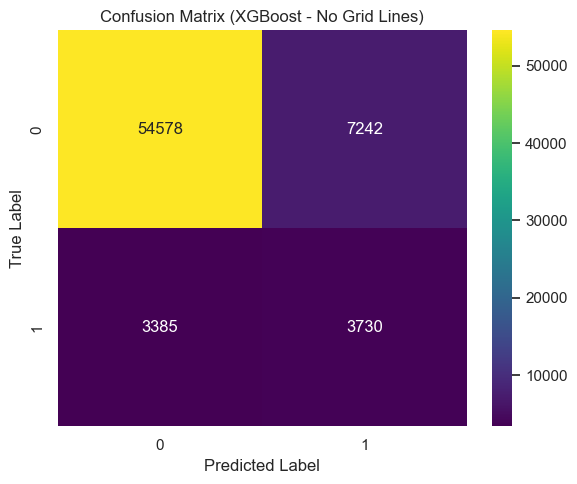

 XGBoost pipeline model saved as 'XGBoost_pipeline_model.pkl'


In [105]:

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        subsample=1.0,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(" Classification Report (XGBoost):\n")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True, linewidths=0, linecolor='none')
plt.title("Confusion Matrix (XGBoost - No Grid Lines)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



joblib.dump(pipeline, "XGBoost_pipeline_model.pkl")
print(" XGBoost pipeline model saved as 'XGBoost_pipeline_model.pkl'")



Visualized Feature Importance Across Models:
Retrieved feature importances from Random Forest, Decision Tree, and XGBoost pipelines.
Mapped features from the preprocessing output.
Plotted the top 10 influential features for each model using horizontal bar graphs.

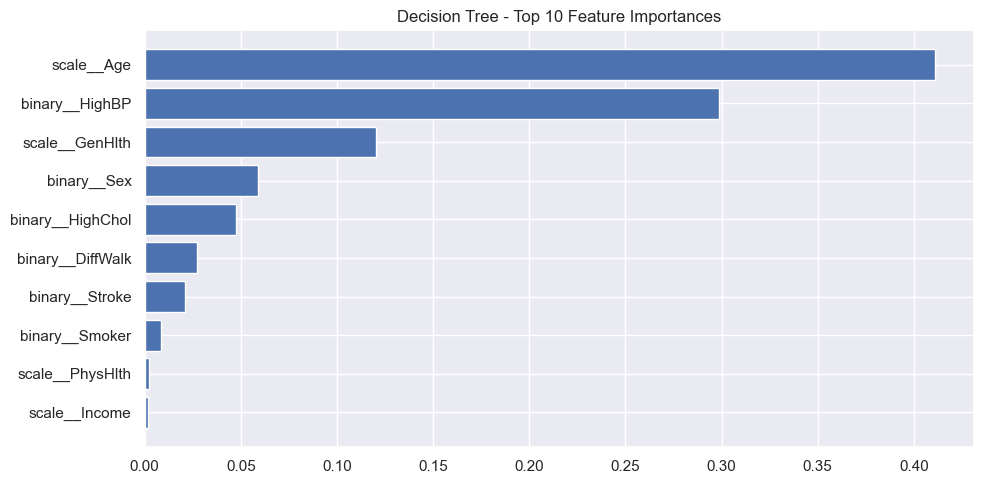

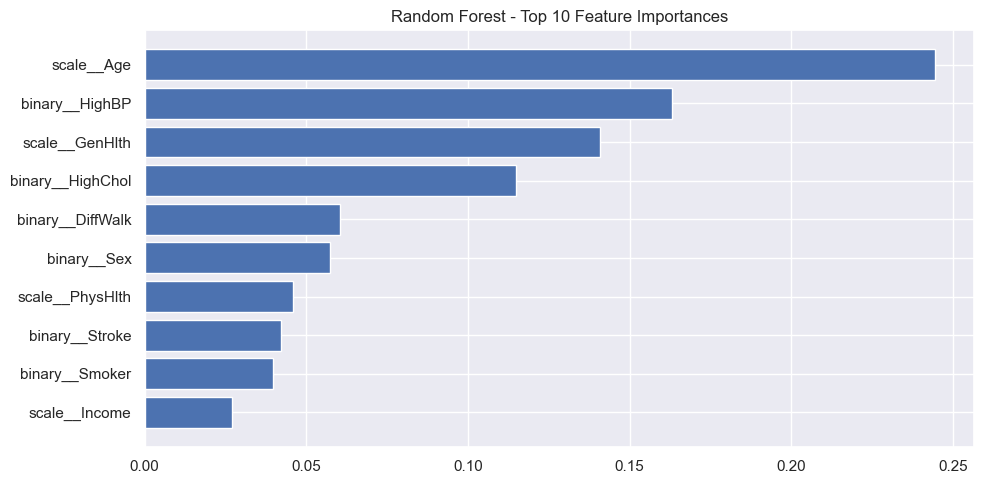

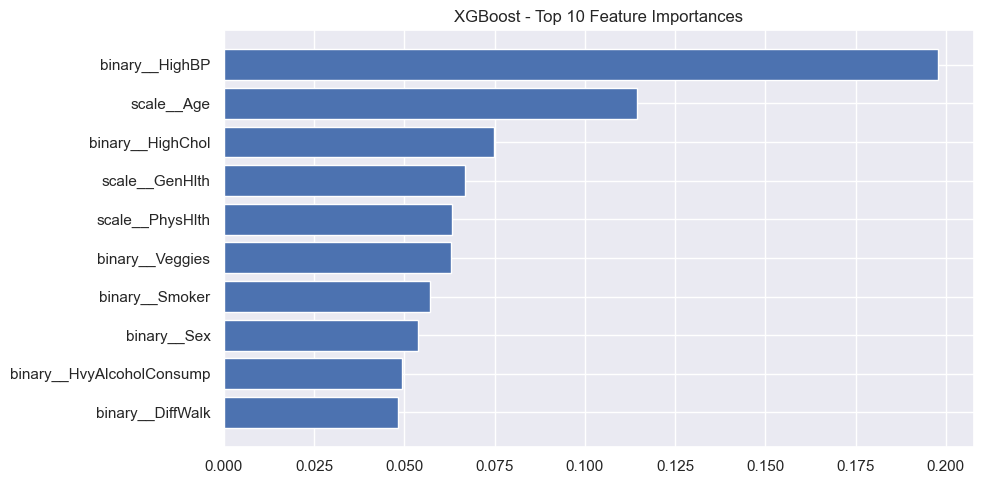

In [83]:
for name, file in model_files.items():
    if name in ["Random Forest", "Decision Tree", "XGBoost"]:
        model = joblib.load(file)
        clf = model.named_steps['classifier']
        features = preprocessor.get_feature_names_out()
        importances = clf.feature_importances_

        feat_df = pd.DataFrame({
            'Feature': features,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 5))
        plt.barh(feat_df['Feature'][:10][::-1], feat_df['Importance'][:10][::-1])
        plt.title(f"{name} - Top 10 Feature Importances")
        plt.tight_layout()
        plt.show()


Cross-Model Feature Importance Analysis:
Trained pipelines for Decision Tree, Random Forest, and XGBoost were loaded.
Feature names were retrieved from the preprocessing pipeline and paired with corresponding model-specific importance scores.
Feature importance scores were consolidated into a single DataFrame to enable consistent comparison across models.
The average importance of each feature was computed and used to rank features.
A comparative horizontal bar plot was generated to visualize and contrast feature importances across all models.

<Figure size 1200x1000 with 0 Axes>

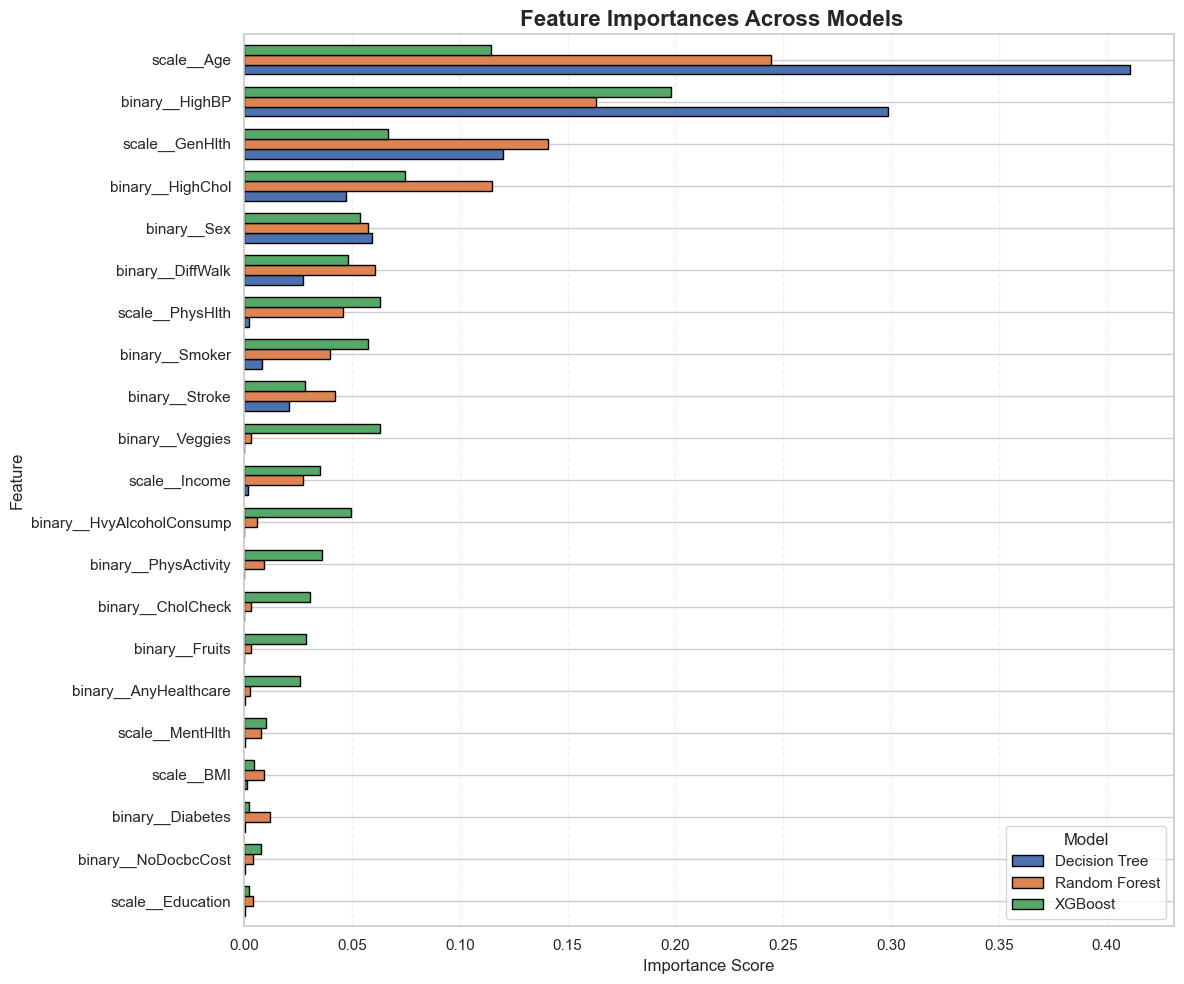

In [110]:

model_files = {
    "Decision Tree": "DecisionTree_pipeline_model.pkl",
    "Random Forest": "RandomForest_pipeline_model.pkl",
    "XGBoost": "XGBoost_pipeline_model.pkl"
}

df_combined = pd.DataFrame()

for model_name, path in model_files.items():
    pipeline = joblib.load(path)
    
   
    feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
    
    
    classifier = pipeline.named_steps["classifier"]
    importances = classifier.feature_importances_
    
    df = pd.DataFrame({
        "Feature": feature_names,
        model_name: importances
    })
    
  
    if df_combined.empty:
        df_combined = df
    else:
        df_combined = pd.merge(df_combined, df, on="Feature", how="outer")


df_combined = df_combined.fillna(0)
df_combined["Average"] = df_combined.drop(columns=["Feature"]).mean(axis=1)
df_combined = df_combined.sort_values(by="Average", ascending=True)

plt.figure(figsize=(12, 10))
df_combined.set_index("Feature").drop(columns=["Average"]).plot(
    kind='barh', figsize=(12, 10), width=0.7, edgecolor='black'
)

plt.title(" Feature Importances Across Models", fontsize=16, weight='bold')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


Model Accuracy Visualization
Compared Logistic Regression, Decision Tree, Random Forest, and XGBoost.
Computed and plotted test set accuracies.
Annotated each bar with accuracy values for clear comparison.

/var/folders/86/yt7z0g3j3xbds04jw0_x0sqr0000gn/T/ipykernel_14965/2930157732.py:41: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/mky/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


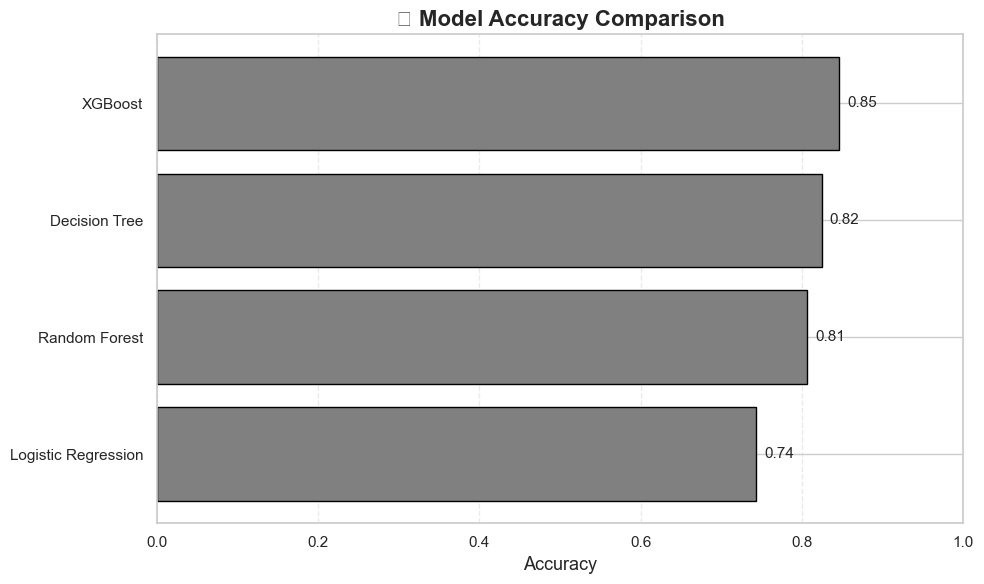

In [104]:

model_files = {
    "XGBoost": "XGBoost_pipeline_model.pkl",
    "Decision Tree": "DecisionTree_pipeline_model.pkl",
    "Random Forest": "RandomForest_pipeline_model.pkl",
    "Logistic Regression": "LogisticRegression_pipeline_model.pkl"
}

accuracy_data = []

for name, file in model_files.items():
    model = joblib.load(file)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_data.append((name, acc))

df_acc = pd.DataFrame(accuracy_data, columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(df_acc["Model"], df_acc["Accuracy"], color='gray', edgecolor='black')
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va='center', fontsize=11)

plt.title("Model Accuracy Comparison", fontsize=16, weight='bold')
plt.xlabel("Accuracy", fontsize=13)
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


ROC Curve Comparison for All Classifiers
Loaded trained models (Logistic Regression, Decision Tree, Random Forest, XGBoost).
Predicted class probabilities on the test set.
Plotted ROC curves and reported AUC scores for each model.
Added a baseline diagonal to represent random chance for reference.

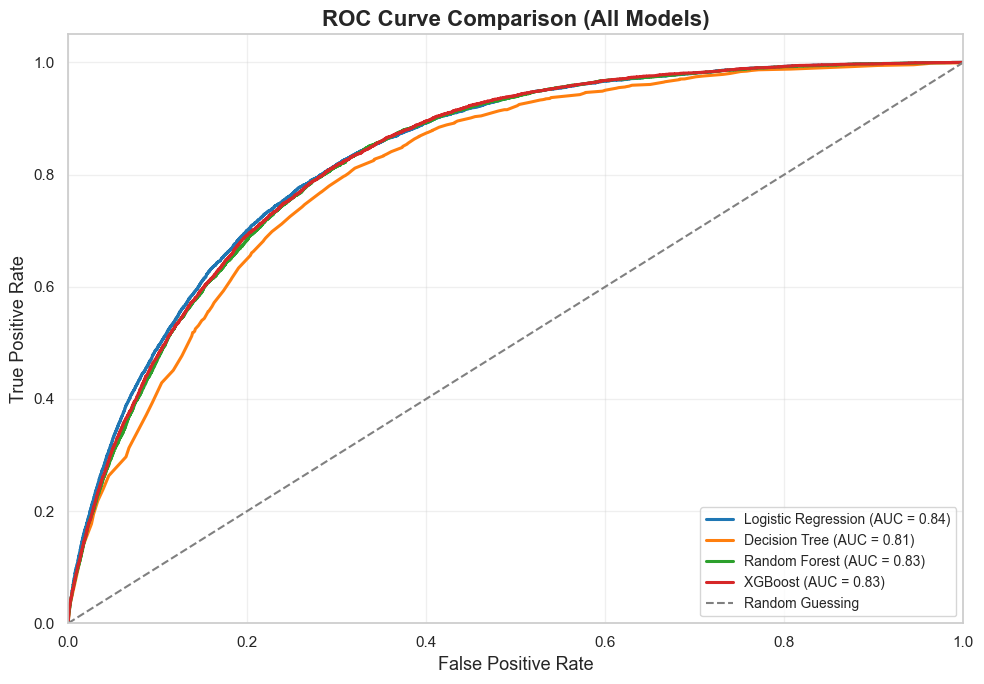

In [100]:

model_files = {
    "Logistic Regression": "LogisticRegression_pipeline_model.pkl",
    "Decision Tree": "DecisionTree_pipeline_model.pkl",
    "Random Forest": "RandomForest_pipeline_model.pkl",
    "XGBoost": "XGBoost_pipeline_model.pkl"
}

colors = {
    "Logistic Regression": "#1f77b4",
    "Decision Tree": "#ff7f0e",
    "Random Forest": "#2ca02c",
    "XGBoost": "#d62728"
}

plt.figure(figsize=(10, 7))

for name, path in model_files.items():
    model = joblib.load(path)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})", linewidth=2.2, color=colors[name])


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guessing")
plt.title("ROC Curve Comparison (All Models)", fontsize=16, weight='bold')
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()


Precision-Recall vs Threshold Analysis (All Models)
Loaded trained models: Logistic Regression, Decision Tree, Random Forest, and XGBoost.
Computed precision and recall across a range of probability thresholds.
Plotted precision and recall curves for each model.
Highlighted the decision threshold at 0.5 to illustrate precision-recall trade-offs.

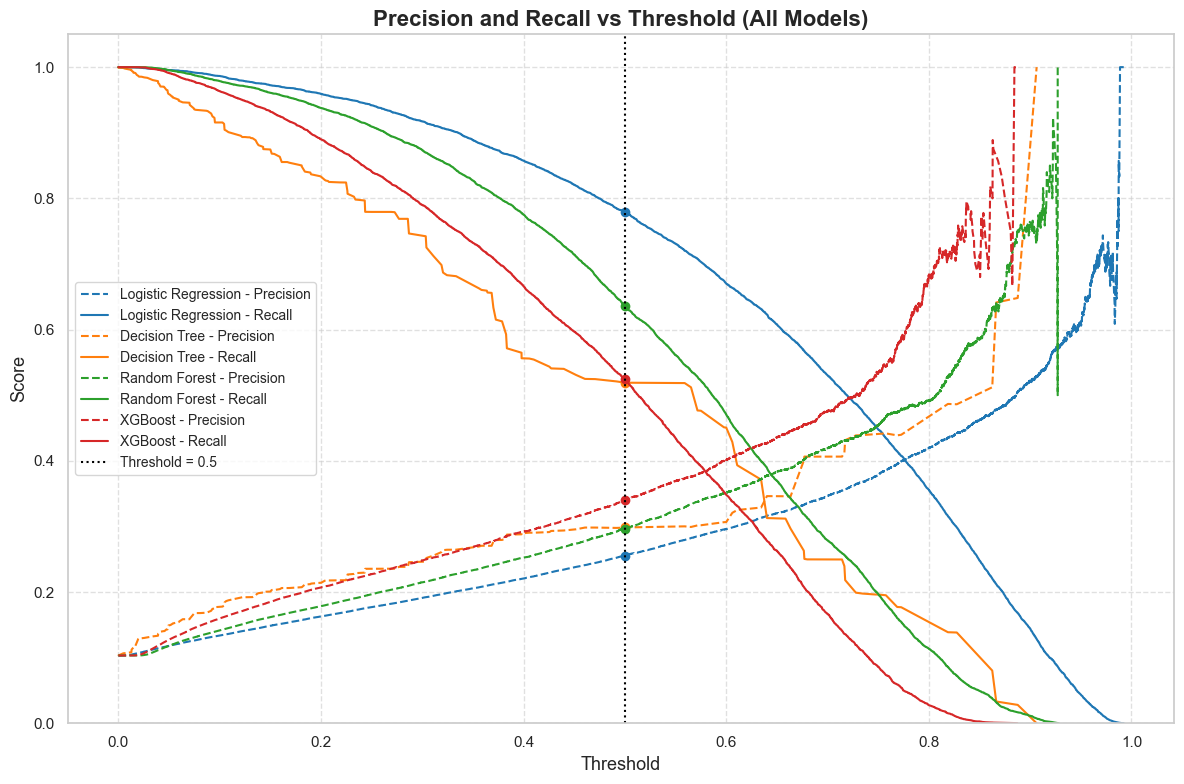

In [99]:

model_files = {
    "Logistic Regression": "LogisticRegression_pipeline_model.pkl",
    "Decision Tree": "DecisionTree_pipeline_model.pkl",
    "Random Forest": "RandomForest_pipeline_model.pkl",
    "XGBoost": "XGBoost_pipeline_model.pkl"
}

plt.figure(figsize=(12, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
threshold_target = 0.5

for idx, (name, path) in enumerate(model_files.items()):
    model = joblib.load(path)
    y_proba = model.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    thresholds_full = np.insert(thresholds, 0, 0.0)
    th_idx = np.argmin(np.abs(thresholds_full - threshold_target))


    plt.plot(thresholds_full, precision, linestyle='--', color=colors[idx], label=f'{name} - Precision')
    plt.plot(thresholds_full, recall, linestyle='-', color=colors[idx], label=f'{name} - Recall')

  
    plt.plot(thresholds_full[th_idx], precision[th_idx], 'o', color=colors[idx])
    plt.plot(thresholds_full[th_idx], recall[th_idx], 'o', color=colors[idx])


plt.axvline(threshold_target, linestyle=':', color='black', label='Threshold = 0.5')
plt.title("Precision and Recall vs Threshold (All Models)", fontsize=16, weight='bold')
plt.xlabel("Threshold", fontsize=13)
plt.ylabel("Score", fontsize=13)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc="best", fontsize=10)
plt.tight_layout()
plt.show()
